# Customer Segmentation using K-Means Clustering
## Project Objective (วัตถุประสงค์)
โครงการนี้มีวัตถุประสงค์เพื่อจัดกลุ่มลูกค้า (Customer Segmentation) โดยใช้ข้อมูลพฤติกรรมการใช้จ่ายจากบัตรเครดิต ด้วยเทคนิค **K-Means Clustering** เพื่อให้เข้าใจพฤติกรรมของลูกค้าแต่ละกลุ่ม และนำไปสู่การวางกลยุทธ์ทางการตลาดที่เหมาะสม (Targeted Marketing)

## Dataset (ข้อมูลที่ใช้)
ข้อมูลที่ใช้มาจาก `CreditCardCustomer.csv` โดยเราจะโฟกัสไปที่ตัวแปรสำคัญ 3 ตัวได้แก่:
1. **Credit_Limit**: วงเงินบัตรเครดิต
2. **Total_Trans_Amt**: ยอดใช้จ่ายรวม (Total Transaction Amount)
3. **Total_Trans_Ct**: จำนวนครั้งที่รูดบัตร (Total Transaction Count)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ตั้งค่าการแสดงผลกราฟให้สวยงาม
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading & Exploration (โหลดและสำรวจข้อมูล)

In [12]:
# Load Dataset
data_path = "C:/Users/HP/Downloads/CreditCardCustomer.csv"
df = pd.read_csv(data_path)

# Show first 5 rows
print("--- ข้อมูล 5 แถวแรก ---")
display(df.head())

--- ข้อมูล 5 แถวแรก ---


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [13]:
# เลือก Features ที่จะใช้ในการทำ Clustering
selected_features = ['Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct']
X = df[selected_features]

# ตรวจสอบข้อมูลเบื้องต้นและค่า Missing Values
print("\n--- ข้อมูลทางสถิติของ Features ที่เลือก ---")
display(X.describe())

print("\n--- ตรวจสอบ Missing Values ---")
print(X.isnull().sum())


--- ข้อมูลทางสถิติของ Features ที่เลือก ---


,Credit_Limit,Total_Trans_Amt,Total_Trans_Ct
count,10127.000000,10127.000000,10127.000000
mean,8631.953698,4404.086304,64.858695
std,9088.776650,3397.129254,23.472570
min,1438.300000,510.000000,10.000000
25%,2555.000000,2155.500000,45.000000
50%,4549.000000,3899.000000,67.000000
75%,11067.500000,4741.000000,81.000000
max,34516.000000,18484.000000,139.000000



--- ตรวจสอบ Missing Values ---
Credit_Limit       0
Total_Trans_Amt    0
Total_Trans_Ct     0
dtype: int64


## 2. Exploratory Data Analysis (EDA)
ก่อนเข้าสู่โมเดล เราจะทำการสำรวจการกระจายตัวของข้อมูลและความสัมพันธ์ระหว่างตัวแปร

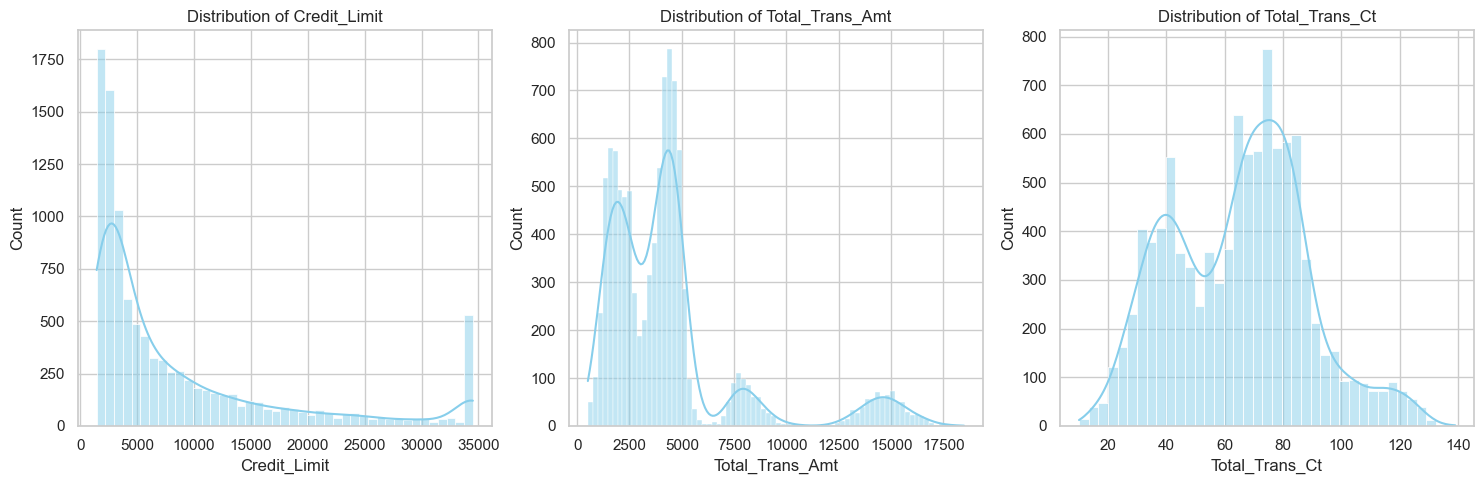

In [14]:
# Distribution Plots (กราฟการกระจายตัว)
plt.figure(figsize=(15, 5))

for i, col in enumerate(selected_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(X[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

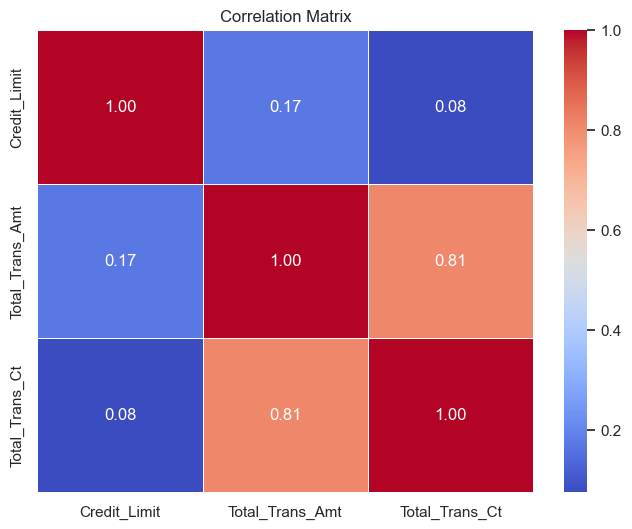

In [15]:
# Correlation Heatmap (ความสัมพันธ์ระหว่างตัวแปร)
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 3. Data Preprocessing (การเตรียมข้อมูล)
เนื่องจาก K-Means ใช้ระยะทาง (Distance) ในการคำนวณ เราจึงจำเป็นต้องทำ **Standard Scaling** ปรับข้อมูลให้อยู่ในสเกลเดียวกัน (Mean=0, Std=1) เพื่อไม่ให้ตัวแปรที่มีค่ามาก (เช่น Credit Limit) มีอิทธิพลเหนือตัวแปรที่มีค่าน้อย

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# แปลงกลับเป็น DataFrame เพื่อให้ดูง่าย
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)
print("--- Data after Scaling (Head) ---")
display(X_scaled_df.head())

--- Data after Scaling (Head) ---


,Credit_Limit,Total_Trans_Amt,Total_Trans_Ct
0,0.446622,-0.959707,-0.973895
1,-0.041367,-0.916433,-1.357340
2,-0.573698,-0.740982,-1.911206
3,-0.585251,-0.951758,-1.911206
4,-0.430877,-1.056263,-1.570365


## 4. Finding Optimal Number of Clusters (การหาจำนวนกลุ่มที่เหมาะสม)
เราจะใช้ 2 วิธีควบคู่กันเพื่อความแม่นยำ:
1. **Elbow Method**: ดูจุดหักศอกของกราฟ Inertia
2. **Silhouette Analysis**: ดูความชัดเจนของการแบ่งกลุ่ม (ค่าเข้าใกล้ 1 ยิ่งดี)

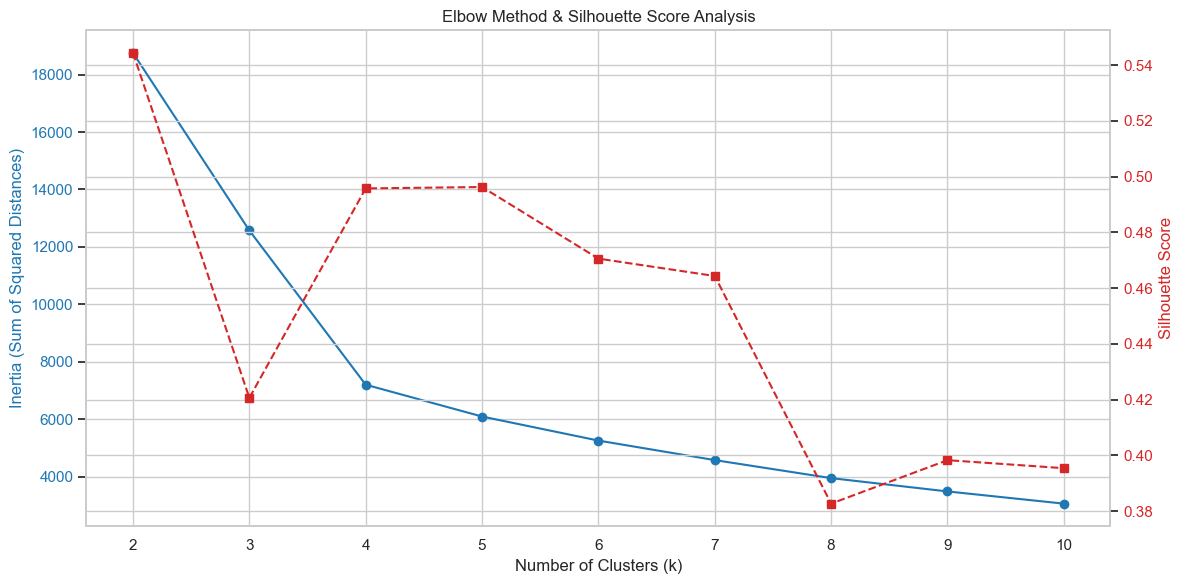

In [17]:
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # ลองแบ่งกลุ่มตั้งแต่ 2 ถึง 10 กลุ่ม

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Create subplot for Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Elbow (Inertia)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of Squared Distances)', color=color)
ax1.plot(k_range, inertia, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Elbow Method & Silhouette Score Analysis')

# Plot Silhouette Score on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

> **Analysis**: จากกราฟ เราจะเลือกค่า **K** ที่เหมาะสมที่สุด (จุดที่ Silhouette Score สูงและ Inertia เริ่มลดลงน้อย) ในที่นี้สมมติว่าเราเลือก **K=4** (หรือตามที่กราฟชี้ชัด)

In [18]:
# เลือก K=4 (สามารถปรับเปลี่ยนได้ตามผลลัพธ์กราฟ)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# บันทึกผลลัพธ์ลงใน DataFrame ต้นฉบับ
df['Cluster'] = clusters

print(f"--- จำนวนลูกค้าในแต่ละกลุ่ม (K={optimal_k}) ---")
print(df['Cluster'].value_counts().sort_index())

--- จำนวนลูกค้าในแต่ละกลุ่ม (K=4) ---
0    3284
1     792
2    1275
3    4776
Name: Cluster, dtype: int64


## 5. Visualizing Clusters with PCA (การแสดงผลด้วย PCA)
เนื่องจากเรามี 3 ตัวแปร (3 มิติ) การมองภาพรวมอาจยาก เราจึงใช้ **PCA (Principal Component Analysis)** เพื่อลดทอนมิติเหลือ 2 มิติ (2D) ทำให้สามารถพล็อตกราฟจุดเพื่อดูการแบ่งกลุ่มได้ชัดเจนขึ้น

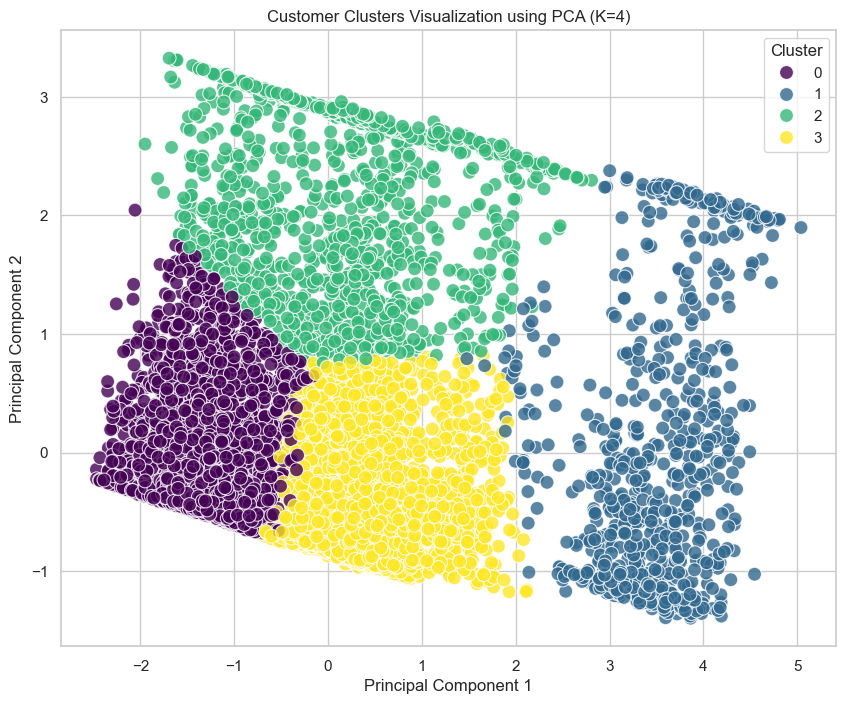

In [19]:
# ลดมิติข้อมูลเหลือ 2 Components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# สร้าง DataFrame สำหรับกราฟ PCA
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f'Customer Clusters Visualization using PCA (K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## 6. Cluster Profiling & Interpretation (การแปลผลทางธุรกิจ)
มาดูพฤติกรรมเฉลี่ยของแต่ละกลุ่ม เพื่อตั้งชื่อและวางกลยุทธ์

--- Cluster Profiles (Mean Values) ---


,Credit_Limit,Total_Trans_Amt,Total_Trans_Ct
Cluster,,,
0,5496.814251,1935.446711,39.836175
1,14255.459596,14361.811869,109.804293
2,27339.901961,3790.615686,61.221961
3,4860.878999,4614.025335,75.581868


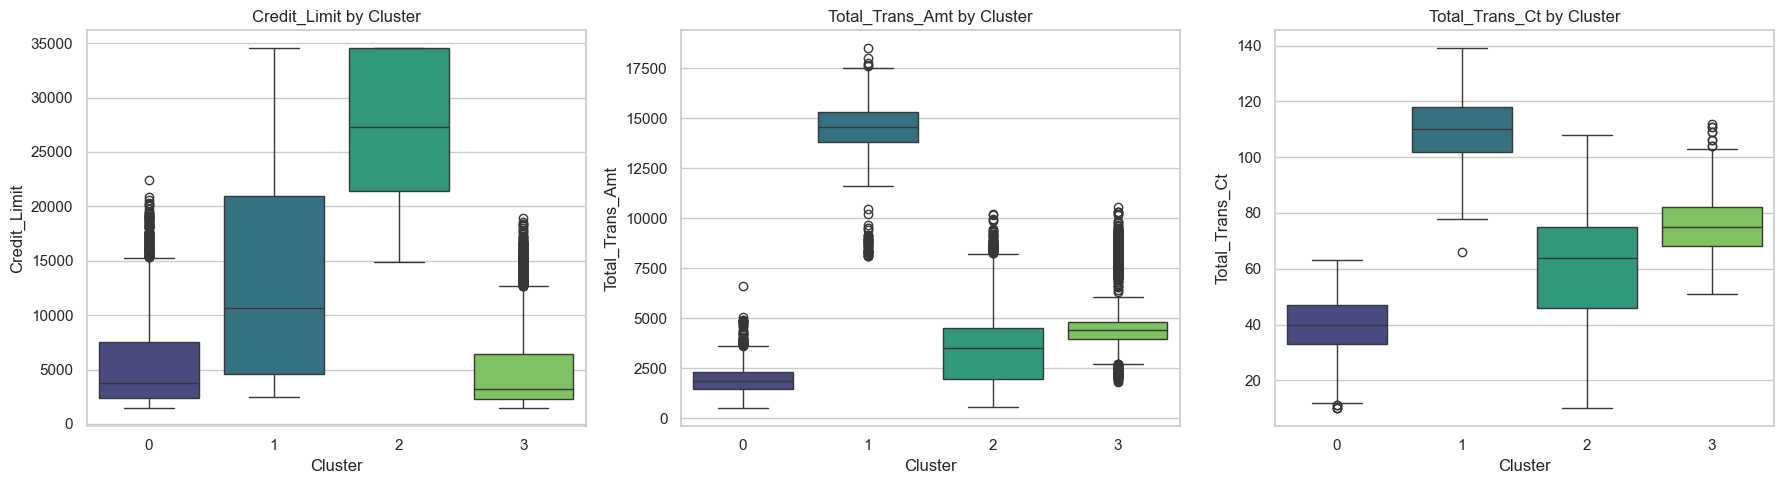

In [20]:
# คำนวณค่าเฉลี่ยของแต่ละ Cluster
cluster_summary = df.groupby('Cluster')[selected_features].mean()
print("--- Cluster Profiles (Mean Values) ---")
display(cluster_summary)

# Visualize Cluster Profiles using Boxplots
plt.figure(figsize=(18, 5))
for i, col in enumerate(selected_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=col, data=df, palette='viridis')
    plt.title(f'{col} by Cluster')

plt.tight_layout()
plt.show()

### 📊 สรุปผลการจัดกลุ่มลูกค้า (Automated Interpretation)

> **🚀 Next Steps:** นำข้อมูล Demographics (อายุ, เพศ) มาวิเคราะห์ร่วมเพื่อทำ Persona ให้ละเอียดขึ้น

---

#### 🔹 Cluster 0: กลุ่มวงเงินต่ำ + ใช้น้อย (Risk: Low Activity / Churn) ⚠️
* **ลักษณะ:** วงเงินต่ำ (Low Limit) และมีการใช้งานน้อยและไม่บ่อย
* **💡 กลยุทธ์:** กระตุ้นการใช้งานด้วยโปรโมชั่น Cashback, ส่วนลดร้านค้าที่ใช้บ่อย
* **📈 Stats:** `Avg Limit: 5,497` | `Avg Amt: 1,935` | `Avg Count: 40`

#### 💎 Cluster 1: กลุ่มวงเงินสูง + ใช้เยอะ (VIP / High Value)
* **ลักษณะ:** วงเงินสูง (High Limit) และมียอดใช้จ่ายเยอะและบ่อย
* **💡 กลยุทธ์:** รักษาฐานลูกค้า VIP ด้วยบริการพิเศษ, เสนอผลิตภัณฑ์การลงทุน
* **📈 Stats:** `Avg Limit: 14,255` | `Avg Amt: 14,362` | `Avg Count: 110`

#### 🔹 Cluster 2: กลุ่มวงเงินสูง + ใช้น้อย (Risk: Low Activity / Churn) ⚠️
* **ลักษณะ:** วงเงินสูง (High Limit) แต่มียอดใช้น้อยและไม่บ่อย
* **💡 กลยุทธ์:** กระตุ้นการใช้งานด้วยโปรโมชั่น Cashback, ส่วนลดร้านค้าที่ใช้บ่อย
* **📈 Stats:** `Avg Limit: 27,340` | `Avg Amt: 3,791` | `Avg Count: 61`

#### 💎 Cluster 3: กลุ่มวงเงินต่ำ + ใช้เยอะ (VIP / High Value)
* **ลักษณะ:** วงเงินต่ำ (Low Limit) แต่ขยันใช้ (ใช้จ่ายเยอะและบ่อย)
* **💡 กลยุทธ์:** รักษาฐานลูกค้า VIP ด้วยบริการพิเศษ, เสนอผลิตภัณฑ์การลงทุน (หรือพิจารณาเพิ่มวงเงิน)
* **📈 Stats:** `Avg Limit: 4,861` | `Avg Amt: 4,614` | `Avg Count: 76`